# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
X_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')

X_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')

X_val = np.load('data/x_val.npy')
y_val = np.load('data/y_val.npy')

# Process

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
def transform_to_images(X, gamma=0.1):

    X_gamma_corrected = np.power(X, gamma) * 255

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_gamma_corrected)
    
    X_padded = np.pad(X_scaled, ((0, 0), (0, 6)), 'constant', constant_values=0)
    images = X_padded.reshape(-1, 8, 8)
    
    return images

In [27]:
image_transform = transforms.Compose([
    transforms.RandomRotation(10),    
    transforms.RandomResizedCrop(8, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
])

def augment_data(X, y, augment_percent=0.2):

    num_samples = X.shape[0]
    num_augmented_samples = int(num_samples * augment_percent)

    indices_to_augment = np.random.choice(num_samples, num_augmented_samples, replace=False)

    X_subset = X[indices_to_augment]
    y_subset = y[indices_to_augment]

    X_subset_tensor = torch.tensor(X_subset, dtype=torch.float32).to(device)
    transformed_images = []
    for image in tqdm(X_subset_tensor, desc="Augmenting images", leave=True):
        transformed_image = image_transform(image.unsqueeze(0)) 
        transformed_image = transformed_image.squeeze(0)
        transformed_image = torch.clamp(transformed_image, 0, 1)
        transformed_images.append(transformed_image)

    X_augmented = torch.stack(transformed_images).cpu().numpy()

    X_combined = np.concatenate((X, X_augmented), axis=0)
    y_combined = np.concatenate((y, y_subset), axis=0)

    return X_combined, y_combined

In [7]:
def display_transformed_image(image):
    """
    Displays a transformed image assuming it has been normalized
    """
    
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)  
    plt.axis('off')  
    plt.show()

In [28]:
X_train_images = transform_to_images(X_train)
X_train_augmented, y_train_augmented = augment_data(X_train_images, y_train)

X_test_images = transform_to_images(X_test)
X_val_images = transform_to_images(X_val)

Augmenting images: 100%|██████████| 89747/89747 [01:29<00:00, 1007.29it/s]


In [32]:
X_train_augmented.max()

1.0

In [33]:
X_train_augmented.min()

0.0

In [29]:
X_train_images.shape

(448735, 8, 8)

In [30]:
X_train_augmented.shape

(538482, 8, 8)

In [31]:
X_test_images[0]

array([[0.9602645 , 0.87055056, 0.50227835, 0.60383581, 0.71338734,
        1.        , 0.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.57501609, 0.57103798],
       [0.61334125, 0.71293379, 0.93303299, 0.714796  , 0.59692653,
        0.34836274, 0.46447507, 0.89877395],
       [0.95872311, 0.65731403, 0.99854888, 0.84741222, 0.79777061,
        0.77036028, 0.7199713 , 0.35524666],
       [0.79748573, 0.64257865, 0.98135161, 0.84664873, 0.09340666,
        0.19920958, 0.6179059 , 0.68690624],
       [0.23041233, 0.20698551, 0.84756933, 0.53968752, 0.9977166 ,
        0.62357002, 0.0046074 , 0.00353555],
       [0.29323287, 0.07040259, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

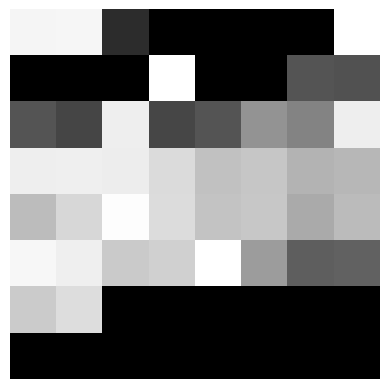

In [34]:
display_transformed_image(X_train_augmented[1])

In [36]:
X_train_augmented = np.array(X_train_augmented)
X_test_images = np.array(X_test_images)
X_val_images = np.array(X_val_images)

X_train_images_tensor = torch.tensor(X_train_augmented, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
X_test_images_tensor = torch.tensor(X_test_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
X_val_images_tensor = torch.tensor(X_val_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

batch_size = 64
train_dataset = TensorDataset(X_train_images_tensor, X_train_images_tensor) 
test_dataset = TensorDataset(X_test_images_tensor, X_test_images_tensor)
val_dataset = TensorDataset(X_val_images_tensor, X_val_images_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# VAE

In [37]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1) # Ou: 32x4x4
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # Ou: 64x2x2
        self.fc1 = nn.Linear(64*2*2, 128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # Flatten into [batch_size, -1]
        x = torch.relu(self.fc1(x))

        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)

        return z_mean, z_log_var

In [38]:
def reparametrize(z_mean, z_log_var):
    std = torch.exp(0.5 * z_log_var)
    eps = torch.randn_like(std)
    return z_mean + eps * std

In [39]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64*2*2)
        self.conv_trans1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1) # Ou: 32x4x4
        self.conv_trans2 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1) # Ou: 1x8x8

    def forward(self, z):
        x = torch.relu(self.fc(z))
        x = x.view(-1, 64, 2, 2)
        x = torch.relu(self.conv_trans1(x))
        x = torch.sigmoid(self.conv_trans2(x)) 
        return x

In [40]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = reparametrize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

In [41]:
def loss_function(reconstructed, original, z_mean, z_log_var):
    
    reconstructed = reconstructed.view(reconstructed.size(0), -1)  # [64, 1, 8, 8] -> [64, 64]
    original = original.view(original.size(0), -1)  # [64, 1, 8, 8] -> [64, 64]

    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed, original, reduction='sum')

    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    
    return reconstruction_loss + kl_divergence

# Train

In [93]:
latent_dim = 64
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
vae = VAE(encoder, decoder)
vae.to(device)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc_mean): Linear(in_features=128, out_features=64, bias=True)
    (fc_log_var): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=256, bias=True)
    (conv_trans1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv_trans2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [94]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0

    # Train
    train_loader_tqdm = tqdm(train_loader, desc=f'Training on epoch {epoch}', leave=True)
    for batch in train_loader_tqdm:
        images, _ = batch
        images = images.to(device).contiguous()
        optimizer.zero_grad()
        
        reconstructed, z_mean, z_log_var = vae(images)
        loss = loss_function(reconstructed, images, z_mean, z_log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #train_loader_tqdm.set_postfix({'Train Loss': train_loss / len(train_loader.dataset)})
    
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')

    # Val
    vae.eval()
    val_loss = 0
    val_loader_tqdm = tqdm(val_loader, desc=f'Validating on epoch {epoch}', leave=True)
    
    with torch.no_grad():
        for val_batch in val_loader_tqdm:
            val_images, _ = val_batch
            val_images = val_images.to(device).contiguous()

            val_reconstructed, val_z_mean, val_z_log_var = vae(val_images)
            val_loss += loss_function(val_reconstructed, val_images, val_z_mean, val_z_log_var).item()
            #val_loader_tqdm.set_postfix({'Validation Loss': val_loss / len(val_loader.dataset)})

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_loader.dataset)}')

Training on epoch 0: 100%|██████████| 8414/8414 [00:24<00:00, 340.79it/s]


Epoch 1, Loss: 24.497013827306873


Validating on epoch 0: 100%|██████████| 1753/1753 [00:02<00:00, 863.54it/s]


Epoch 1, Validation Loss: 34.86967903076816


Training on epoch 1: 100%|██████████| 8414/8414 [00:24<00:00, 344.31it/s]


Epoch 2, Loss: 23.69149546722568


Validating on epoch 1: 100%|██████████| 1753/1753 [00:02<00:00, 872.18it/s]


Epoch 2, Validation Loss: 34.577587833607204


Training on epoch 2: 100%|██████████| 8414/8414 [00:24<00:00, 344.98it/s]


Epoch 3, Loss: 23.608548431904843


Validating on epoch 2: 100%|██████████| 1753/1753 [00:02<00:00, 864.65it/s]


Epoch 3, Validation Loss: 34.38817122502324


Training on epoch 3: 100%|██████████| 8414/8414 [00:24<00:00, 349.59it/s]


Epoch 4, Loss: 23.559348532911443


Validating on epoch 3: 100%|██████████| 1753/1753 [00:02<00:00, 867.12it/s]


Epoch 4, Validation Loss: 34.28680868773796


Training on epoch 4: 100%|██████████| 8414/8414 [00:24<00:00, 349.81it/s]


Epoch 5, Loss: 23.520675833790275


Validating on epoch 4: 100%|██████████| 1753/1753 [00:02<00:00, 872.91it/s]


Epoch 5, Validation Loss: 34.583688918359016


Training on epoch 5: 100%|██████████| 8414/8414 [00:24<00:00, 346.73it/s]


Epoch 6, Loss: 23.486263196158006


Validating on epoch 5: 100%|██████████| 1753/1753 [00:02<00:00, 872.59it/s]


Epoch 6, Validation Loss: 34.30669168421828


Training on epoch 6: 100%|██████████| 8414/8414 [00:24<00:00, 343.11it/s]


Epoch 7, Loss: 23.467810778435954


Validating on epoch 6: 100%|██████████| 1753/1753 [00:02<00:00, 866.81it/s]


Epoch 7, Validation Loss: 34.334129347097665


Training on epoch 7: 100%|██████████| 8414/8414 [00:23<00:00, 358.48it/s]


Epoch 8, Loss: 23.46062395855241


Validating on epoch 7: 100%|██████████| 1753/1753 [00:02<00:00, 871.70it/s]


Epoch 8, Validation Loss: 34.19756273776856


Training on epoch 8: 100%|██████████| 8414/8414 [00:24<00:00, 347.51it/s]


Epoch 9, Loss: 23.442973769082432


Validating on epoch 8: 100%|██████████| 1753/1753 [00:02<00:00, 867.66it/s]


Epoch 9, Validation Loss: 34.27433525171955


Training on epoch 9: 100%|██████████| 8414/8414 [00:24<00:00, 346.46it/s]


Epoch 10, Loss: 23.43486331212564


Validating on epoch 9: 100%|██████████| 1753/1753 [00:02<00:00, 870.18it/s]


Epoch 10, Validation Loss: 34.30903921893768


Training on epoch 10: 100%|██████████| 8414/8414 [00:23<00:00, 362.78it/s]


Epoch 11, Loss: 23.428471827201427


Validating on epoch 10: 100%|██████████| 1753/1753 [00:02<00:00, 869.05it/s]


Epoch 11, Validation Loss: 34.12205129205981


Training on epoch 11: 100%|██████████| 8414/8414 [00:23<00:00, 360.53it/s]


Epoch 12, Loss: 23.417441641158764


Validating on epoch 11: 100%|██████████| 1753/1753 [00:02<00:00, 864.82it/s]


Epoch 12, Validation Loss: 34.74662517761696


Training on epoch 12: 100%|██████████| 8414/8414 [00:24<00:00, 346.57it/s]


Epoch 13, Loss: 23.407611247589


Validating on epoch 12: 100%|██████████| 1753/1753 [00:02<00:00, 872.33it/s]


Epoch 13, Validation Loss: 34.30582478521962


Training on epoch 13: 100%|██████████| 8414/8414 [00:23<00:00, 353.97it/s]


Epoch 14, Loss: 23.403113964610892


Validating on epoch 13: 100%|██████████| 1753/1753 [00:02<00:00, 866.82it/s]


Epoch 14, Validation Loss: 34.3356463708356


Training on epoch 14: 100%|██████████| 8414/8414 [00:23<00:00, 363.74it/s]


Epoch 15, Loss: 23.400607999482514


Validating on epoch 14: 100%|██████████| 1753/1753 [00:02<00:00, 867.89it/s]


Epoch 15, Validation Loss: 34.46527053581651


Training on epoch 15: 100%|██████████| 8414/8414 [00:23<00:00, 360.62it/s]


Epoch 16, Loss: 23.3949463178979


Validating on epoch 15: 100%|██████████| 1753/1753 [00:02<00:00, 874.01it/s]


Epoch 16, Validation Loss: 34.34169921135074


Training on epoch 16: 100%|██████████| 8414/8414 [00:24<00:00, 348.91it/s]


Epoch 17, Loss: 23.391032641648987


Validating on epoch 16: 100%|██████████| 1753/1753 [00:02<00:00, 866.14it/s]


Epoch 17, Validation Loss: 34.76225763998417


Training on epoch 17: 100%|██████████| 8414/8414 [00:23<00:00, 352.82it/s]


Epoch 18, Loss: 23.38914476943584


Validating on epoch 17: 100%|██████████| 1753/1753 [00:02<00:00, 870.58it/s]


Epoch 18, Validation Loss: 34.37702249955291


Training on epoch 18: 100%|██████████| 8414/8414 [00:24<00:00, 340.80it/s]


Epoch 19, Loss: 23.382511882569528


Validating on epoch 18: 100%|██████████| 1753/1753 [00:02<00:00, 867.59it/s]


Epoch 19, Validation Loss: 34.51383808296213


Training on epoch 19: 100%|██████████| 8414/8414 [00:23<00:00, 363.66it/s]


Epoch 20, Loss: 23.376555173360163


Validating on epoch 19: 100%|██████████| 1753/1753 [00:02<00:00, 865.41it/s]

Epoch 20, Validation Loss: 34.57748008303114


In [98]:
torch.save(vae.state_dict(), "vae.pth")

# Visualize

In [95]:
def visualize_reconstruction(vae, data_loader, num_images=5):
    vae.eval()  
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device).contiguous()
            reconstructed, _, _ = vae(images)
            break  

        images = images.cpu().numpy()
        reconstructed = reconstructed.cpu().numpy()
        
        fig, axes = plt.subplots(2, num_images, figsize=(15, 3))
        for i in range(num_images):

            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Original")

            axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed")

        plt.show()

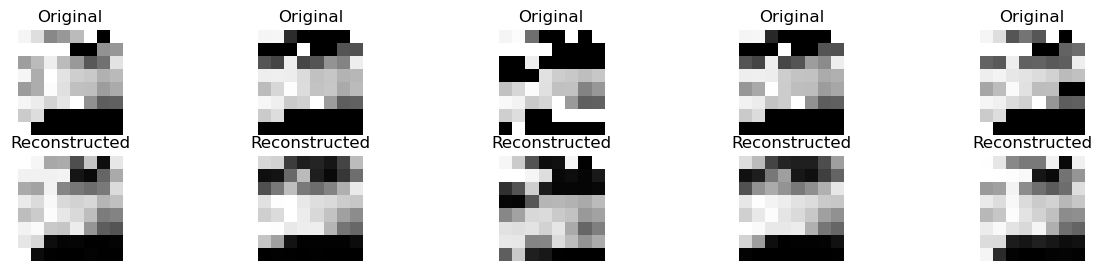

In [96]:
visualize_reconstruction(vae, train_loader)

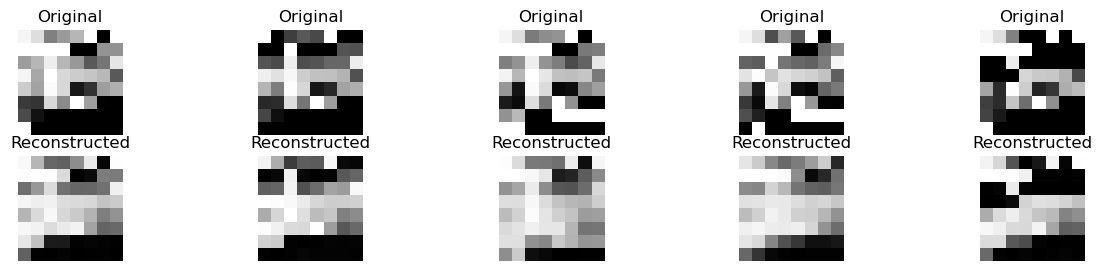

In [97]:
visualize_reconstruction(vae, test_loader)

# Extract Features

In [99]:
vae = VAE(encoder, decoder)
vae.load_state_dict(torch.load("vae.pth"))
vae.eval()

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc_mean): Linear(in_features=128, out_features=64, bias=True)
    (fc_log_var): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=256, bias=True)
    (conv_trans1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv_trans2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [100]:
def extract_features(encoder, dataloader, device):
    encoder.eval() 
    features = []
    with torch.no_grad(): 
        for data in tqdm(dataloader, desc="Extracting features"):
            images, _ = data
            images = images.to(device)
            z_mean, z_log_var = encoder(images)
            features.append(z_mean.cpu().numpy())

    features = np.vstack(features) 
    return features

X_train_features = extract_features(encoder, train_loader, device)
X_test_features = extract_features(encoder, test_loader, device)

Extracting features: 100%|██████████| 2192/2192 [00:01<00:00, 1327.95it/s]


# Model

In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import time

In [102]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 30073,   1823,   1339,  14562,  14165,     18,   3246,  24286,
         13316,     72,   3810, 259964,  49365,    650,  20234,   1354,
           294,    733,   9431]))

In [103]:
normal_data = X_train_features[y_train_augmented == 11] # 11 is normal class

In [104]:
len(normal_data)

311987

In [105]:
def evaluate_model(model, y_test, y_pred):
    positive_class = "normal"
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision = precision_score(y_test, y_pred, pos_label=positive_class)
    recall = recall_score(y_test, y_pred, pos_label=positive_class)
    f1 = f1_score(y_test, y_pred, pos_label=positive_class)
    
    metrics = {
        'model': [model],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1],
    }
    
    return metrics

In [106]:
y_test_binary = np.where(y_test == 11, 'normal', 'anomaly')

# SGDOCSVM

In [107]:
from sklearn.linear_model import SGDOneClassSVM

In [129]:
sgd_svm = SGDOneClassSVM(nu=0.6, verbose=3, eta0=0.01, learning_rate='optimal', tol=0.001)
sgd_svm.fit(X_train_features, y_train_augmented)

-- Epoch 1
Norm: 0.15, NNZs: 64, Bias: 0.925622, T: 538482, Avg. loss: 0.038570
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 0.15, NNZs: 64, Bias: 0.926293, T: 1076964, Avg. loss: 0.037480
Total training time: 0.30 seconds.
-- Epoch 3
Norm: 0.15, NNZs: 64, Bias: 0.926328, T: 1615446, Avg. loss: 0.037198
Total training time: 0.45 seconds.
-- Epoch 4
Norm: 0.15, NNZs: 64, Bias: 0.926288, T: 2153928, Avg. loss: 0.037236
Total training time: 0.60 seconds.
-- Epoch 5
Norm: 0.15, NNZs: 64, Bias: 0.926406, T: 2692410, Avg. loss: 0.037100
Total training time: 0.75 seconds.
-- Epoch 6
Norm: 0.15, NNZs: 64, Bias: 0.926390, T: 3230892, Avg. loss: 0.037118
Total training time: 0.90 seconds.
-- Epoch 7
Norm: 0.15, NNZs: 64, Bias: 0.926653, T: 3769374, Avg. loss: 0.037039
Total training time: 1.05 seconds.
Convergence after 7 epochs took 1.05 seconds


SGDOneClassSVM(eta0=0.01, nu=0.6, verbose=3)

In [130]:
y_pred_sgd_svm = sgd_svm.predict(X_test_features)
y_preds_sgd_svm_binary = np.where(y_pred_sgd_svm == 1, 'normal', 'anomaly')

In [131]:
results_sgd_svm = pd.DataFrame(evaluate_model("SGDOCSVM", y_test_binary, y_preds_sgd_svm_binary))
results_sgd_svm

,model,accuracy,precision,recall,f1
0,SGDOCSVM,0.68844,0.674948,0.891591,0.768289


# IF

In [132]:
from sklearn.ensemble import IsolationForest

In [151]:
model_if = IsolationForest(n_estimators=200, max_samples=256, contamination=0.001, verbose=1)
model_if.fit(X_train_features, y_train)

IsolationForest(contamination=0.001, max_samples=256, n_estimators=200,
                verbose=1)

In [152]:
y_pred_if = model_if.predict(X_test_features)
y_preds_if_binary = np.where(y_pred_if == 1, 'normal', 'anomaly')

In [153]:
results_if = pd.DataFrame(evaluate_model("IF", y_test_binary, y_preds_if_binary))
results_if

,model,accuracy,precision,recall,f1
0,IF,0.567839,0.574548,0.978914,0.724102


# PCA Reconstruction

In [154]:
from sklearn.decomposition import PCA

In [174]:
pca_start = time()

pca = PCA(n_components=15, whiten=True, svd_solver='auto')

normal_data_pca = pca.fit_transform(normal_data)
normal_data_reconstructed = pca.inverse_transform(normal_data_pca)

reconstruction_error = np.mean((normal_data - normal_data_reconstructed) ** 2, axis=1)

threshold = np.percentile(reconstruction_error, 95)

X_test_pca = pca.transform(X_test_features)
X_test_reconstructed = pca.inverse_transform(X_test_pca)
X_test_reconstruction_error = np.mean((X_test_features - X_test_reconstructed) ** 2, axis=1)

print(f"seconds: {time() - pca_start}")

seconds: 0.14447760581970215


In [175]:
y_pred_test_pca = np.where(X_test_reconstruction_error > threshold, 'anomaly', 'normal')
y_test_converted_pca = np.where(y_test == 11, 'normal', 'anomaly')

In [176]:
pca_df = pd.DataFrame(evaluate_model('PCA Reconstruction', y_test_converted_pca, y_pred_test_pca))
pca_df

,model,accuracy,precision,recall,f1
0,PCA Reconstruction,0.727483,0.698714,0.93108,0.798332


# LOF

In [177]:
from sklearn.neighbors import LocalOutlierFactor

In [185]:
lof_model = LocalOutlierFactor(n_neighbors=100, contamination=0.05)
lof_model.fit(X_train_features, y_train_augmented)

LocalOutlierFactor(contamination=0.05, n_neighbors=100)

In [186]:
y_pred_lof = lof_model.fit_predict(X_test_features)
y_preds_lof_binary = np.where(y_pred_lof == 1, 'normal', 'anomaly')

In [187]:
lof_df = pd.DataFrame(evaluate_model("LOF", y_test_binary, y_preds_lof_binary))
lof_df

,model,accuracy,precision,recall,f1
0,LOF,0.581808,0.584808,0.958985,0.726551
